Installing Libraries

In [ ]:
!pip install fastapi uvicorn pyngrok nest_asyncio

`ngrok` requires an authenticated account and authtoken to work. Follow these steps to resolve the issue:

1. Sign Up for an ngrok Account:
Go to ngrok's [signup page](https://dashboard.ngrok.com/signup) and create a free account.

2. Get Your Authtoken:
After signing up, go to ngrok's [authtoken page](https://dashboard.ngrok.com/get-started/your-authtoken) to get your authtoken.

3. Install Your Authtoken:
Use the following command in your Colab notebook to authenticate ngrok with your authtoken. Replace YOUR_AUTHTOKEN with the authtoken you obtained in the previous step.

In [ ]:
# CHANGE YOUR_AUTHTOKEN IN THE LINE BELOW

!ngrok config add-authtoken YOUR_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


Importing Libraries

In [ ]:
import nest_asyncio
import uvicorn
from fastapi import FastAPI
from pyngrok import ngrok

# GET Request

In [ ]:
app = FastAPI()

# Example data store
predictions = {
    1: {"input": [5.1, 3.5, 1.4, 0.2], "output": "setosa"},
    2: {"input": [7.0, 3.2, 4.7, 1.4], "output": "versicolor"},
}

@app.get("/predictions/{prediction_id}")
def read_prediction(prediction_id: int):
    return predictions.get(prediction_id, {"error": "Prediction not found"})

In [ ]:
# Apply nest_asyncio to allow the server to run within the notebook
nest_asyncio.apply()

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Start the server
uvicorn.run(app, host="0.0.0.0", port=8000)

After running the cell, you will see a public URL printed in the output. You can use this URL to access your FastAPI endpoints.

Click on "Visit Site" when prompted to a window with a page similar to this when going at the above URL:

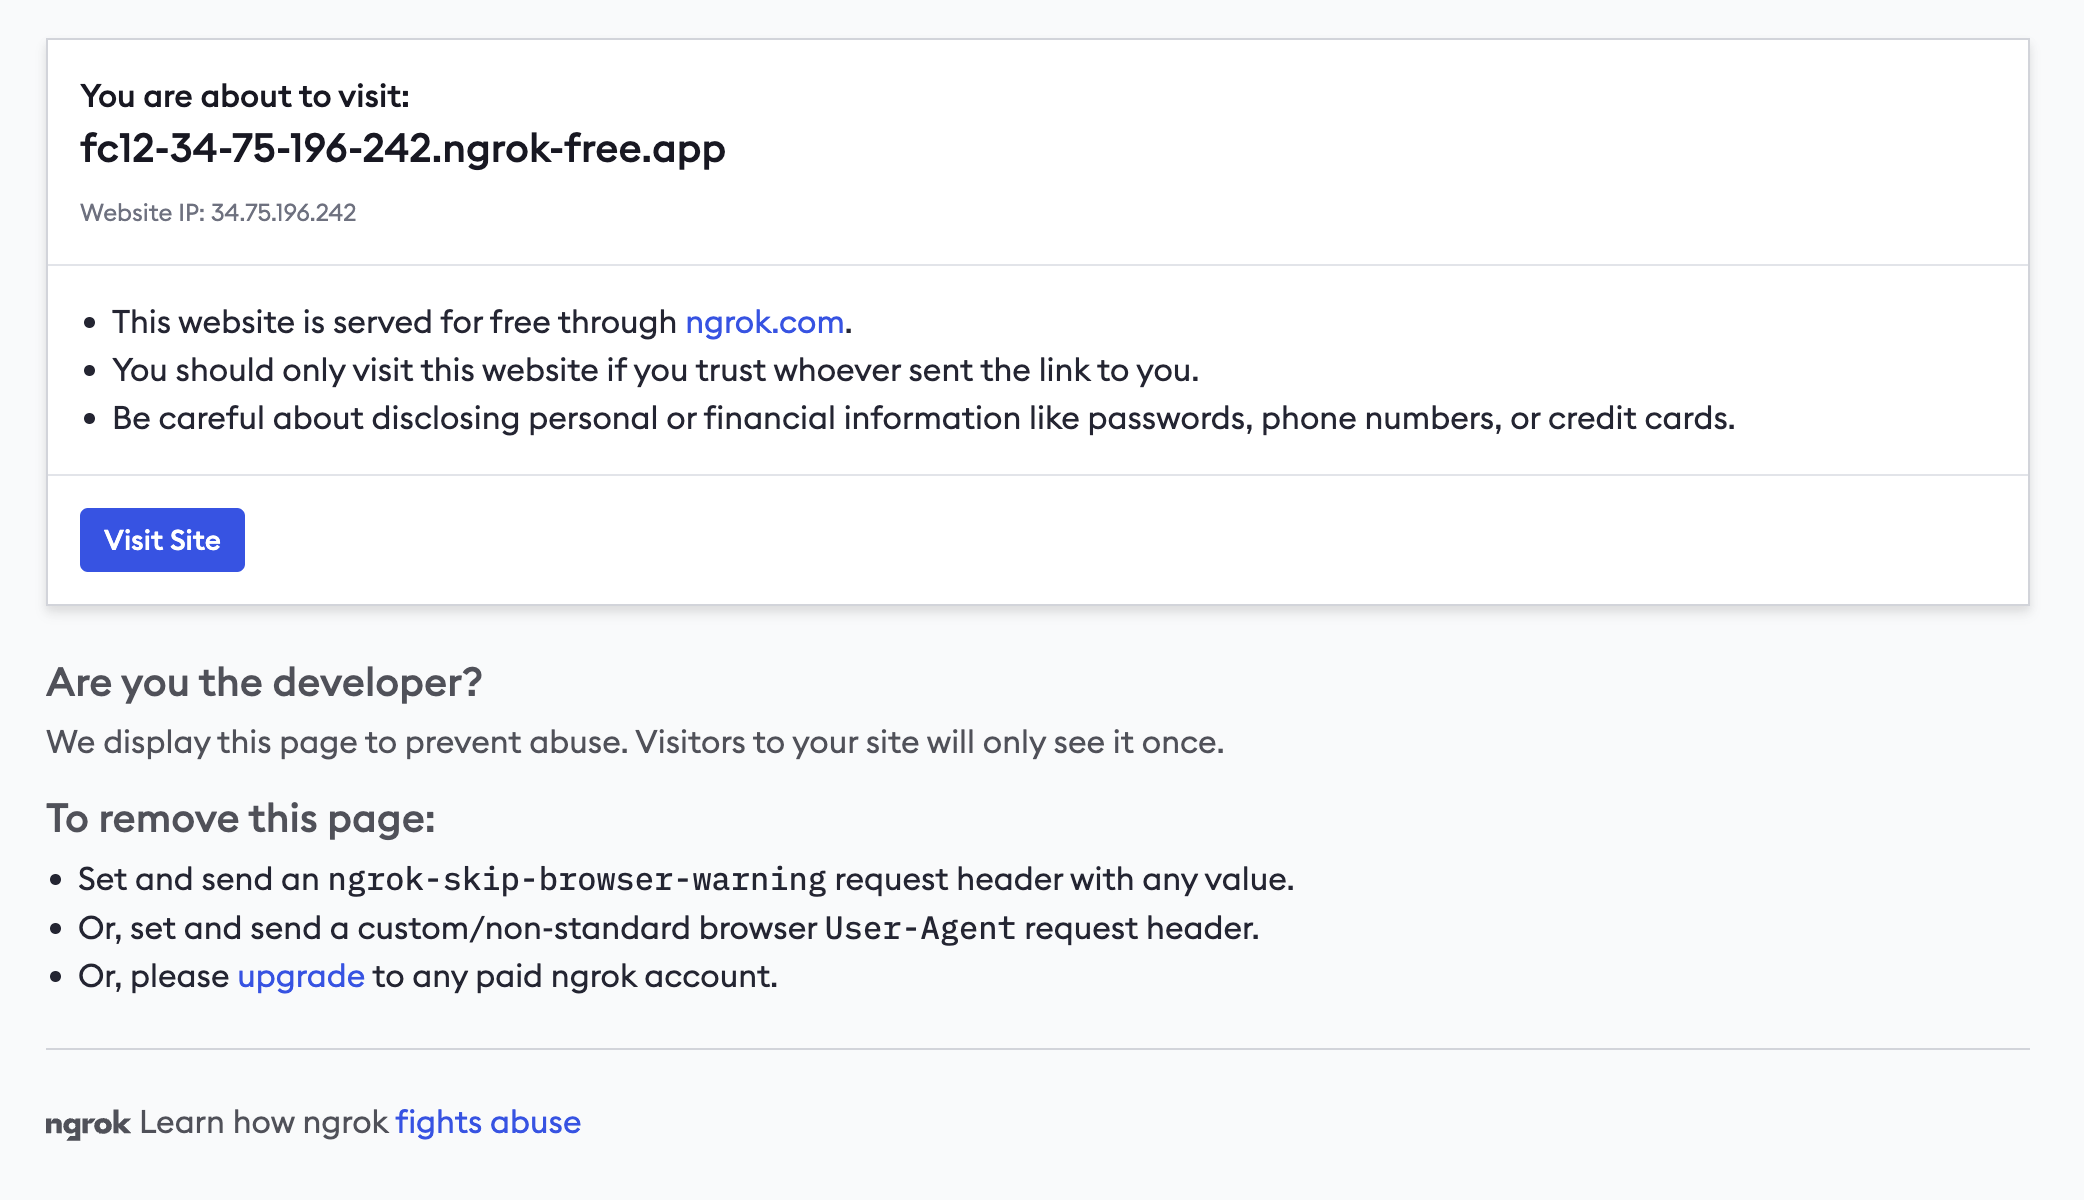

To get the prediction with ID 1 update the above public url with this suffix: `/predictions/1`

In this case, Public URL was: https://6170-34-168-14-71.ngrok-free.app

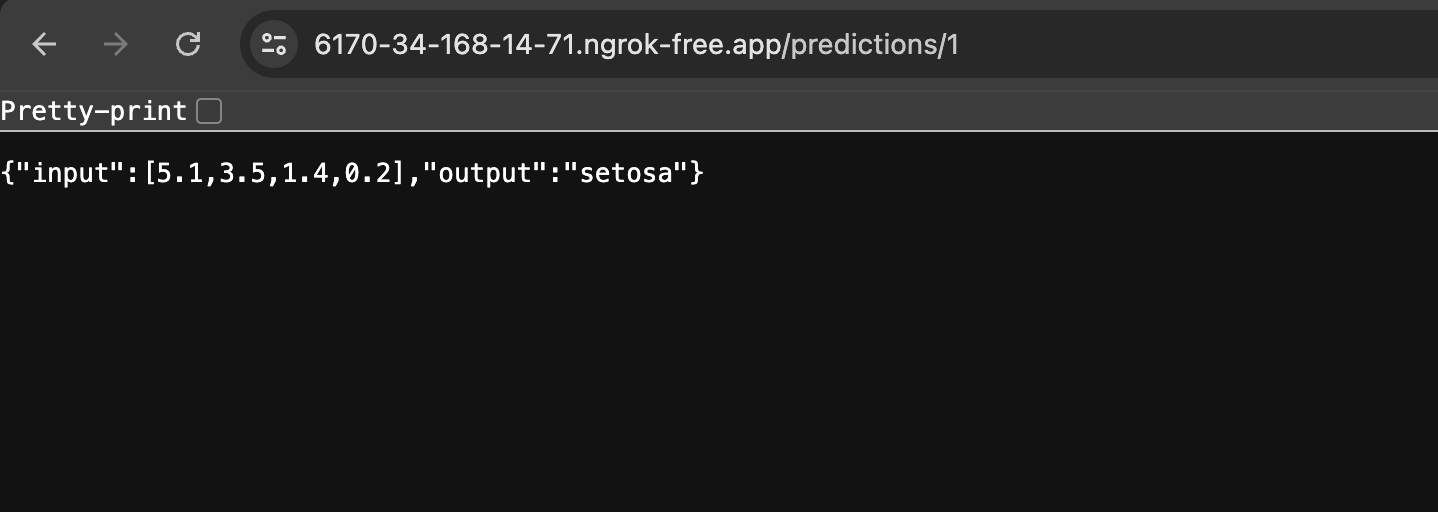

In the code we have defined output of predictions for id 1 and 2 only, If we try to hit the url with any other number it will dispaly prediction not found message as defined in the code.

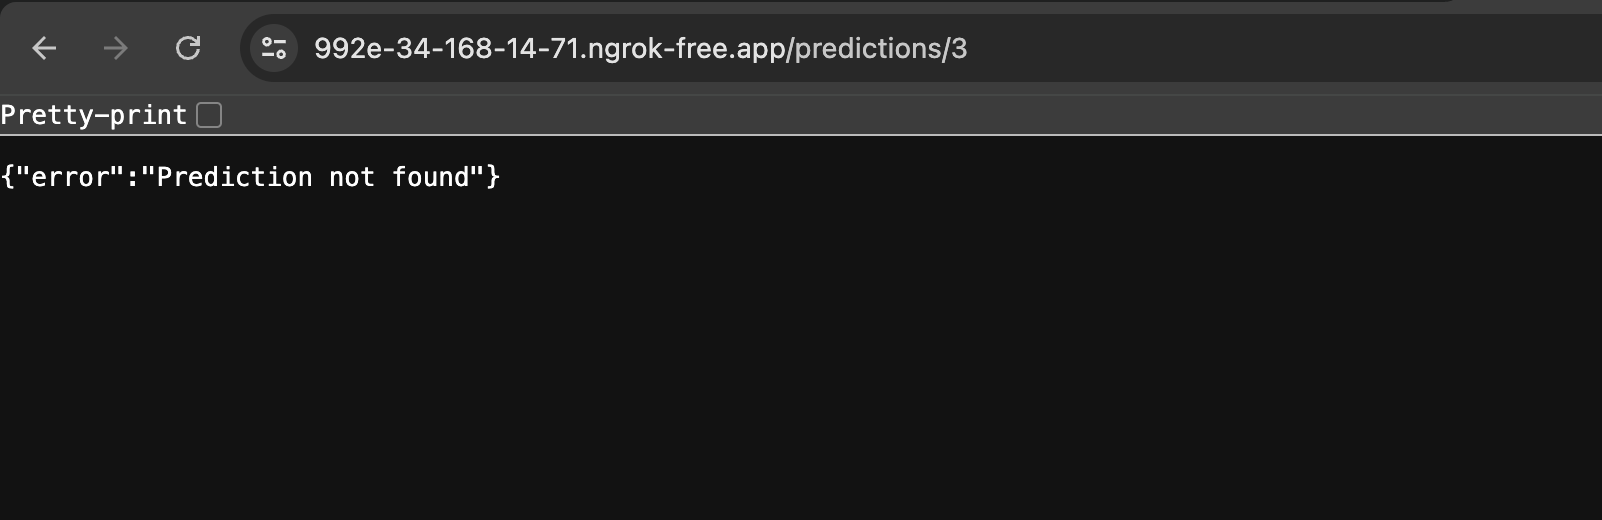

### -> Note: if the code does not work as expected, then go to runtime and restart the session:

# POST Request

The below code is for POST API Call where we will add some extra key-value pairs in our `predictions` dictionary.

At present, there are 2 keys for number 1 and 2. We will run the following code blocks, which will run our server in back ended in Colab and simultaneously running the next cells will update our dictionary with keys 3, 4, and so on.

In [ ]:
%%writefile fastapi_server.py
from pydantic import BaseModel
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
from pyngrok import ngrok

app = FastAPI()

# Example data store
predictions = {
    1: {"input": [5.1, 3.5, 1.4, 0.2], "output": "setosa"},
    2: {"input": [7.0, 3.2, 4.7, 1.4], "output": "versicolor"},
}

class PredictionRequest(BaseModel):
    features: list[float]

def get_dummy_prediction(features: list[float]) -> str:
    return "dummy_flower_type"

@app.post("/predict")
def create_prediction(request: PredictionRequest):
    prediction_output = get_dummy_prediction(request.features)
    prediction_id = len(predictions) + 1
    prediction = {"input": request.features, "output": prediction_output}
    predictions[prediction_id] = prediction
    return prediction

@app.get("/predictions/{prediction_id}")
def read_prediction(prediction_id: int):
    return predictions.get(prediction_id, {"error": "Prediction not found"})

if __name__ == "__main__":
    ngrok_tunnel = ngrok.connect(8000)
    print('Public URL:', ngrok_tunnel.public_url)
    uvicorn.run(app, host="0.0.0.0", port=8000)

Writing fastapi_server.py


In [ ]:
import subprocess
import time

# Start the FastAPI server in a separate process
server_process = subprocess.Popen(["python", "fastapi_server.py"])

# Wait for a moment to allow the server to start
time.sleep(5)

# Get the ngrok URL
ngrok_url = !curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"
if ngrok_url:
    print("Server is running. Public URL:", ngrok_url[0])
else:
    print("Failed to retrieve ngrok URL.")

Server is running. Public URL: https://794c-34-31-66-73.ngrok-free.app


Try to test the above API for example `https://f295-35-237-113-71.ngrok-free.app/predictions/1` and it will generate the expected outcome for key 1, know if we change the prediction ID to 3 it will say production not found.

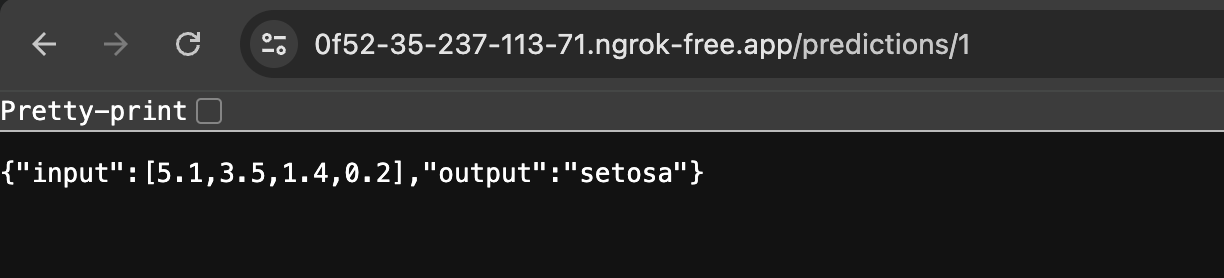

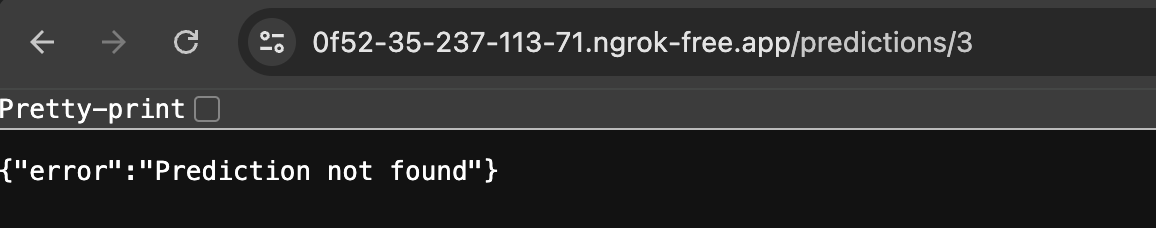


Let's add key-val pair for id 3.

Copy the URL printed above and paste it below in place of `YOUR_NGROK_URL`. Now, as many times we run the below cell, it will append a new key value pair starting with index 3.

After running the below cell once, if we refresh the api page, we will get result for if 3.

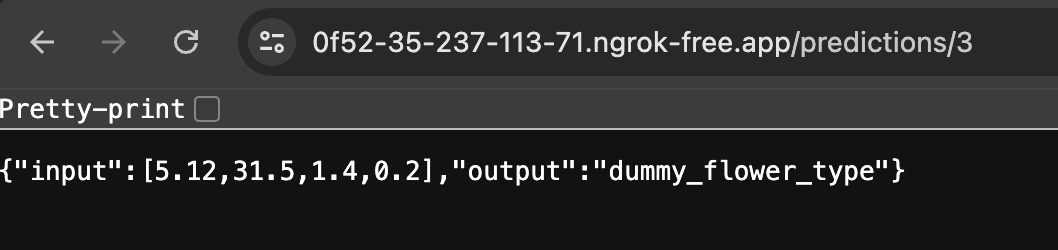

In [ ]:
import requests

# Replace with the URL printed by the previous cell
base_url = "YOUR_NGROK_URL"  # Replace this with your URL

# Test the predict endpoint
response = requests.post(f"{base_url}/predict", json={"features": [5.12, 31.5, 1.4, 0.2]})
print("Predict response:", response.json())

Predict response: {'input': [5.12, 31.5, 1.4, 0.2], 'output': 'dummy_flower_type'}


Similarly if we run the cell again, we will be able to retrive result for id 4.

Run the cell at last to stop the server.


In [ ]:
server_process.terminate()
print("Server has been stopped.")

Server has been stopped.


# PUT API

Instead of having `dummy_flower_type` type for the output for production ID three let's change it to, `setosa`.

In [ ]:
%%writefile fastapi_server2.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
from pyngrok import ngrok

app = FastAPI()

# Example data store
predictions = {
    1: {"input": [5.1, 3.5, 1.4, 0.2], "output": "setosa"},
    2: {"input": [7.0, 3.2, 4.7, 1.4], "output": "versicolor"},
}

class PredictionRequest(BaseModel):
    features: list[float]

class UpdatePredictionOutputRequest(BaseModel):
    output: str

def get_dummy_prediction(features: list[float]) -> str:
    return "dummy_flower_type"

@app.post("/predict")
def create_prediction(request: PredictionRequest):
    prediction_output = get_dummy_prediction(request.features)
    prediction_id = len(predictions) + 1
    prediction = {"input": request.features, "output": prediction_output}
    predictions[prediction_id] = prediction
    return {"id": prediction_id, **prediction}

@app.get("/predictions/{prediction_id}")
def read_prediction(prediction_id: int):
    prediction = predictions.get(prediction_id)
    if prediction is None:
        raise HTTPException(status_code=404, detail="Prediction not found")
    return prediction

@app.put("/predictions/{prediction_id}")
def update_prediction_output(prediction_id: int, request: UpdatePredictionOutputRequest):
    if prediction_id in predictions:
        predictions[prediction_id]["output"] = request.output
        return predictions[prediction_id]
    raise HTTPException(status_code=404, detail="Prediction not found")

if __name__ == "__main__":
    ngrok_tunnel = ngrok.connect(8000)
    print('Public URL:', ngrok_tunnel.public_url)
    uvicorn.run(app, host="0.0.0.0", port=8000)

Writing fastapi_server2.py


In [ ]:
import subprocess
import time

# Start the FastAPI server in a separate process
server_process = subprocess.Popen(["python", "fastapi_server2.py"])

# Wait for a moment to allow the server to start
time.sleep(5)

# Start Ngrok tunnel
ngrok_process = subprocess.Popen(["ngrok", "http", "8000"])

# Wait for a moment to allow the Ngrok tunnel to start
time.sleep(5)

# Get the ngrok URL
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

print("Server is running. You can now test your API.")

https://2a3d-34-31-66-73.ngrok-free.app
Server is running. You can now test your API.


We are changing the output value of prediction ID 1.

Current value: 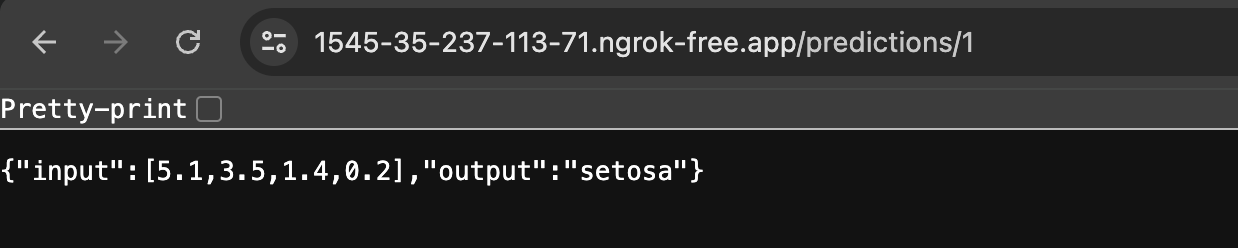

Change the base URL to your server URL in the below cell.

In [ ]:
import requests

# Replace with the URL printed by the previous cell
base_url = "YOUR_NGROK_URL"  # Replace this with your URL

prediction_id = 1

# Check if the prediction ID is returned correctly
if prediction_id is None:
    raise ValueError("Failed to get prediction ID from the response")

# Test the PUT endpoint to update the output of the created prediction
update_response = requests.put(f"{base_url}/predictions/{prediction_id}", json={"output": "new_output_value"})
print("Update response:", update_response.json())

Update response: {'input': [5.1, 3.5, 1.4, 0.2], 'output': 'new_output_value'}


Updated value after running the above cell (remember to refresh the page):

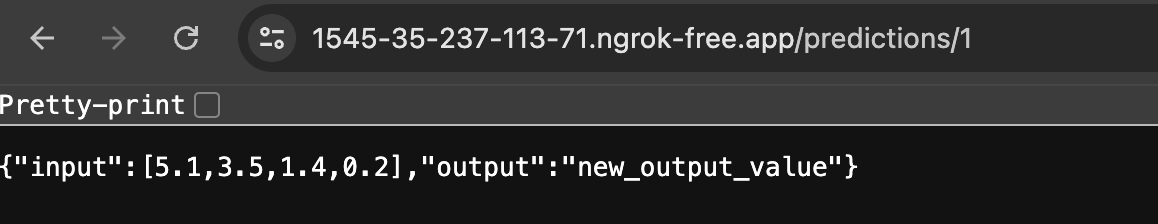

In [ ]:
server_process.terminate()
print("Server has been stopped.")

Server has been stopped.


# DELETE Request

Finally, let's try the delete request by deleting the prediction ID 1.

In [ ]:
%%writefile fastapi_server3.py
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import uvicorn
from pyngrok import ngrok

app = FastAPI()

# Example data store
predictions = {
    1: {"input": [5.1, 3.5, 1.4, 0.2], "output": "setosa"},
    2: {"input": [7.0, 3.2, 4.7, 1.4], "output": "versicolor"},
}

class PredictionRequest(BaseModel):
    features: list[float]

class UpdatePredictionOutputRequest(BaseModel):
    output: str

def get_dummy_prediction(features: list[float]) -> str:
    return "dummy_flower_type"

@app.post("/predict")
def create_prediction(request: PredictionRequest):
    prediction_output = get_dummy_prediction(request.features)
    prediction_id = len(predictions) + 1
    prediction = {"input": request.features, "output": prediction_output}
    predictions[prediction_id] = prediction
    return prediction

@app.get("/predictions/{prediction_id}")
def read_prediction(prediction_id: int):
    prediction = predictions.get(prediction_id)
    if prediction is None:
        raise HTTPException(status_code=404, detail="Prediction not found")
    return prediction

@app.put("/predictions/{prediction_id}/output")
def update_prediction_output(prediction_id: int, request: UpdatePredictionOutputRequest):
    if prediction_id in predictions:
        predictions[prediction_id]["output"] = request.output
        return predictions[prediction_id]
    raise HTTPException(status_code=404, detail="Prediction not found")

@app.delete("/predictions/{prediction_id}")
def delete_prediction(prediction_id: int):
    if prediction_id in predictions:
        del predictions[prediction_id]
        return {"message": "Prediction deleted"}
    raise HTTPException(status_code=404, detail="Prediction not found")

if __name__ == "__main__":
    ngrok_tunnel = ngrok.connect(8000)
    print('Public URL:', ngrok_tunnel.public_url)
    uvicorn.run(app, host="0.0.0.0", port=8000)

Overwriting fastapi_server3.py


In [ ]:
import subprocess
import time

# Start the FastAPI server in a separate process
server_process = subprocess.Popen(["python", "fastapi_server3.py"])

# Wait for a moment to allow the server to start
time.sleep(5)

# Get the ngrok URL
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

print("Server is running. You can now test your API.")

https://c80d-34-31-66-73.ngrok-free.app
Server is running. You can now test your API.


We will get response when we hit to above URL at /predition/1 endpoint. If we delete the id 1 after running the below code, it will no longer be present.

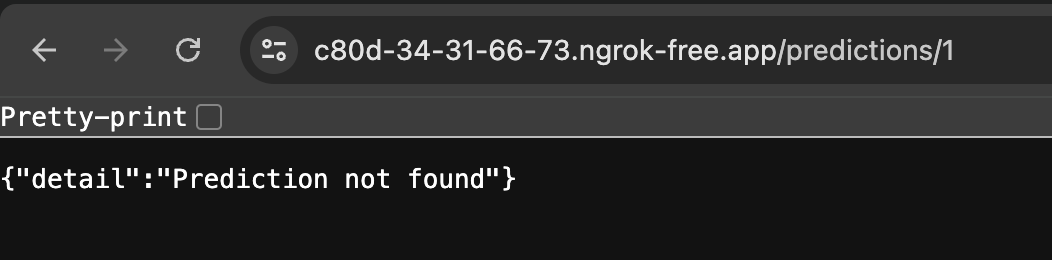

In [ ]:
import requests

# Replace with the actual ngrok URL printed by your server
base_url = "YOUR_NGROK_URL"

prediction_id = 1

# Function to delete a prediction
def delete_prediction(prediction_id):
    response = requests.delete(f"{base_url}/predictions/{prediction_id}")
    return response.json()

# Test the delete_prediction function
if prediction_id:
    deletion_result = delete_prediction(prediction_id)
    print("Deletion result:", deletion_result)
else:
    print("Failed to delete prediction.")

Deletion result: {'message': 'Prediction deleted'}


In [ ]:
server_process.terminate()
print("Server has been stopped.")

Server has been stopped.
